<a href="https://www.kaggle.com/code/andreynesterov/home-credit-baseline-data?scriptVersionId=162403520" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

**Based on:**

https://www.kaggle.com/code/greysky/home-credit-baseline

Changes:
1. Removed model training code (contains only data collection and preproccessing; utility script)
1. Added function prepare_df
1. Added new aggregations: min, mean, mode, first, last


**Related notebooks**

Training model-1 notebook:

https://www.kaggle.com/andreynesterov/home-credit-baseline-training

Inference notebook:

https://www.kaggle.com/andreynesterov/home-credit-baseline-inference

# Dependencies

In [1]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

# Configuration

In [2]:
class CFG:
    root_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/")
    train_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train")
    test_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test")

## Feature definitions

In [3]:
if __name__ == '__main__':
    feature_definitions_df = pd.read_csv(CFG.root_dir / "feature_definitions.csv")
    display(feature_definitions_df)
    pd.reset_option("display.max_rows", 0)

,Variable,Description
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...
1,actualdpdtolerance_344P,DPD of client with tolerance.
2,addres_district_368M,District of the person's address.
3,addres_role_871L,Role of person's address.
4,addres_zip_823M,Zip code of the address.
5,amount_1115A,Credit amount of the active contract provided ...
6,amount_416A,Deposit amount.
7,amount_4527230A,Tax deductions amount tracked by the governmen...
8,amount_4917619A,Tax deductions amount tracked by the governmen...
9,amtdebitincoming_4809443A,Incoming debit card transactions amount.


# Data Collection and Preprocessing

### Pipeline

In [4]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

### Automatic Aggregation

In [5]:
class Aggregator:
    num_aggregators = [pl.max, pl.min, pl.first, pl.last, pl.mean]
    str_aggregators = [pl.max, pl.min, pl.first, pl.last]
    
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_all = []
        for method in Aggregator.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]
        expr_all = []
        for method in Aggregator.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_all = []
        for method in Aggregator.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr
            
        expr_mode = [
            pl.col(col)
            .drop_nulls()
            .mode()
            .first()
            .alias(f"mode_{col}")
            for col in cols
        ]

        return expr_all + expr_mode

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_all = []
        for method in Aggregator.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_all = []
        for method in Aggregator.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

### File I/O

In [6]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        chunks.append(pl.read_parquet(path).pipe(Pipeline.set_table_dtypes))
        
    df = pl.concat(chunks, how="vertical_relaxed")
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

### Feature Engineering

In [7]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [8]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data

In [9]:
### from https://www.kaggle.com/code/batprem/home-credit-risk-mode-utility-scripts

def reduce_mem_usage(df, float16_as32=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)                    
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Prepare df

In [10]:
def prepare_df(data_dir, cat_cols=None, mode="train", display_store=False, train_cols=[]):
    print("Collecting data...")
    data_store = {
        "df_base": read_file(data_dir / f"{mode}_base.parquet"),
        "depth_0": [
            read_file(data_dir / f"{mode}_static_cb_0.parquet"),
            read_files(data_dir / f"{mode}_static_0_*.parquet"),
        ],
        "depth_1": [
            read_files(data_dir / f"{mode}_applprev_1_*.parquet", 1),
            read_file(data_dir / f"{mode}_tax_registry_a_1.parquet", 1),
            read_file(data_dir / f"{mode}_tax_registry_b_1.parquet", 1),
            read_file(data_dir / f"{mode}_tax_registry_c_1.parquet", 1),
            read_file(data_dir / f"{mode}_credit_bureau_b_1.parquet", 1),
            read_file(data_dir / f"{mode}_other_1.parquet", 1),
            read_file(data_dir / f"{mode}_person_1.parquet", 1),
            read_file(data_dir / f"{mode}_deposit_1.parquet", 1),
            read_file(data_dir / f"{mode}_debitcard_1.parquet", 1),
        ],
        "depth_2": [
            read_file(data_dir / f"{mode}_credit_bureau_b_2.parquet", 2),
        ]
    }
    if display_store:
        display(data_store)
    
    print("Feature engeneering...")
    feats_df = feature_eng(**data_store)
    print("  feats_df shape:\t", feats_df.shape)
    
    del data_store
    gc.collect()
    
    print("Filter cols...")
    if mode == "train":
        feats_df = feats_df.pipe(Pipeline.filter_cols)
    else:
        feats_df = feats_df.select([col for col in train_cols if col != "target"])
    print("  feats_df shape:\t", feats_df.shape)
    
    print("Convert to pandas...")
    feats_df = to_pandas(feats_df, cat_cols)
    return feats_df

In [11]:
if __name__ == '__main__':
    train_df = prepare_df(CFG.train_dir)
    cat_cols = list(train_df.select_dtypes("category").columns)

Feature engeneering...
  feats_df shape:	 (1526659, 927)
Filter cols...
  feats_df shape:	 (1526659, 516)
Convert to pandas...


In [12]:
if __name__ == '__main__':
    display(train_df)

,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_60

In [13]:
if __name__ == '__main__':
    display(cat_cols)

['description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'requesttype_4525192L',
 'bankacctype_710L',
 'cardtype_51L',
 'credtype_322L',
 'disbursementtype_67L',
 'equalitydataagreement_891L',
 'inittransactioncode_186L',
 'isdebitcard_729L',
 'lastapprcommoditycat_1041M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'lastst_736L',
 'opencred_647L',
 'paytype1st_925L',
 'paytype_783L',
 'twobodfilling_608L',
 'typesuite_864L',
 'max_cancelreason_3545846M',
 'max_education_1138M',
 'max_postype_4733339M',
 'max_rejectreason_755M',
 'max_rejectreasonclient_4145042M',
 'min_cancelreason_3545846M',
 'min_education_1138M',
 'min_postype_4733339M',
 'min_rejectreason_755M',
 'min_rejectreasonclient_4145042M',
 'first_cancelreason_3545846M',
 'first_education_1138M',
 'first_postype_4733339M',
 'first_rejectreason_755M',
 'first_rejectreas

In [14]:
if __name__ == '__main__':
    test_df = prepare_df(CFG.test_dir, cat_cols=cat_cols, mode="test", train_cols=train_df.columns)

Feature engeneering...
  feats_df shape:	 (10, 926)
Filter cols...
  feats_df shape:	 (10, 515)
Convert to pandas...


In [15]:
if __name__ == '__main__':
    display(test_df)

,case_id,WEEK_NUM,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,type

### Reduce memory usage and save

In [16]:
if __name__ == '__main__':
    train_df = reduce_mem_usage(train_df)
    test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 4574.60 MB
Memory usage after optimization is: 2357.21 MB
Decreased by 48.5%
Memory usage of dataframe is 0.05 MB
Memory usage after optimization is: 0.04 MB
Decreased by 15.4%


In [17]:
if __name__ == '__main__':
    train_df.to_parquet("train_full.parquet")

### EDA

In [18]:
if __name__ == '__main__':
    print("Train is duplicated:\t", train_df["case_id"].duplicated().any())
    print("Train Week Range:\t", (train_df["WEEK_NUM"].min(), train_df["WEEK_NUM"].max()))

    print()

    print("Test is duplicated:\t", test_df["case_id"].duplicated().any())
    print("Test Week Range:\t", (test_df["WEEK_NUM"].min(), test_df["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (92, 92)


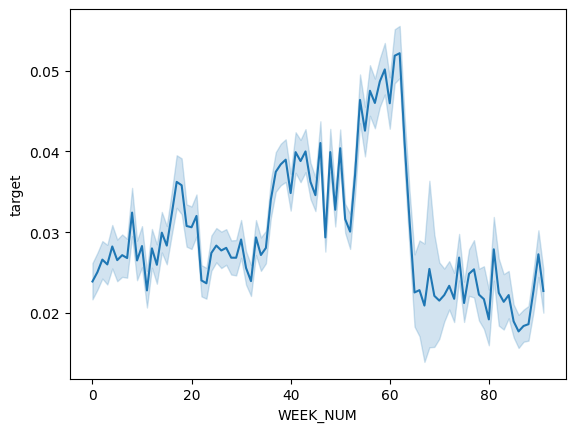

In [19]:
if __name__ == '__main__':
    sns.lineplot(
        data=train_df,
        x="WEEK_NUM",
        y="target",
    )
    plt.show()